In [54]:
import kagglehub
import pandas as pd
import re
import spacy
from transformers import pipeline
import os
import yfinance as yf
import matplotlib.pyplot as plt
import random as r
from collections import Counter
from spacy import displacy

Import the data

In [55]:
# Download latest version of the dataset
path = kagglehub.dataset_download("gpreda/reddit-wallstreetsbets-posts")

print("Path to dataset files:", path)

csv_file_path = os.path.join(path, "reddit_wsb.csv")


Path to dataset files: /Users/tugbagozlek/.cache/kagglehub/datasets/gpreda/reddit-wallstreetsbets-posts/versions/106


In [56]:
df = pd.read_csv(csv_file_path)
print(df.columns)

Index(['title', 'score', 'id', 'url', 'comms_num', 'created', 'body',
       'timestamp'],
      dtype='object')


In [57]:
print(df.shape[0])

53187


In [58]:
# Only keep some of the columns
df=df[['title', 'score', 'comms_num', 'body',
       'timestamp']]

Filter the data

In [59]:
# Drop rows with NaN-values and duplicate rows
df = df.dropna()
df= df.drop_duplicates()

In [60]:
print(df.shape[0])

24737


In [61]:
# Filter the data by time
df = df[df['timestamp'].str.startswith('2021-01') | df['timestamp'].str.startswith('2021-02')]
print(df.shape[0])

18542


Descriptive analysis

In [63]:
df['date']=pd.to_datetime(df.timestamp).dt.date
df['hour']=pd.to_datetime(df.timestamp).dt.hour
df['day']=pd.to_datetime(df.timestamp).dt.day_name()

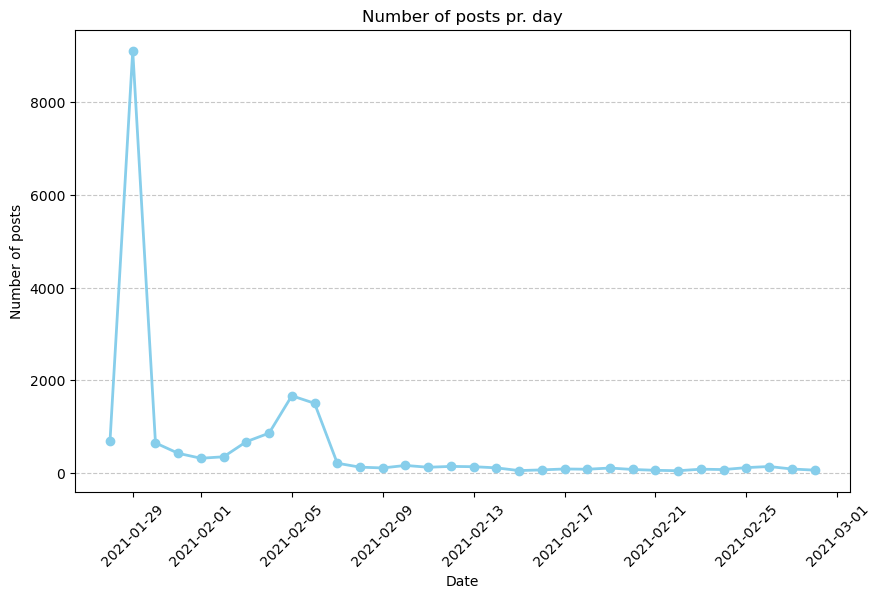

In [66]:
# Calculate number of posts pr day
day_counts = df.groupby('date')['body'].count()
plt.figure(figsize=(10, 6))

# Plot the graph
plt.plot(day_counts.index, day_counts.values, marker='o', color='skyblue', linestyle='-', linewidth=2)

# Add labels and titel
plt.xlabel('Date')  
plt.ylabel('Number of posts')  
plt.title('Number of posts pr. day') 

# Rotate the labels of the x-axis
plt.xticks(rotation=45)

# Add grids
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the graph
plt.show()

Average length of the posts

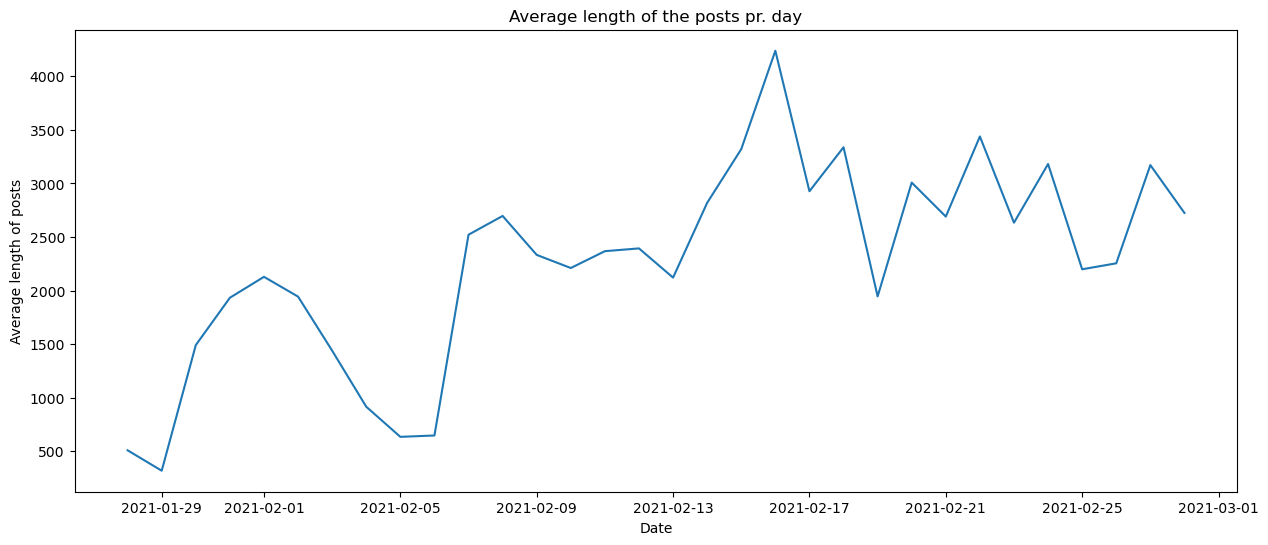

In [67]:
# Calculate the average length of the posts
df['text_length'] = df['body'].apply(len)
day_length = df.groupby('date')['text_length'].mean()

plt.figure(figsize=(15, 6))
plt.plot(day_length.index, day_length.values)
plt.title('Average length of the posts pr. day')
plt.xlabel('Date')
plt.ylabel('Average length of posts')
plt.show()

Clean the text in the posts

In [68]:
nlp = spacy.load("en_core_web_sm")
def clean_text(text):
    cleaned_text = re.sub(r'http\S+|www\.\S+', '',text) # Remove URL's
    cleaned_text = cleaned_text.strip()  # Strip leading and trailing whitespace
    cleaned_text = " ".join(cleaned_text.split()) # Remove extra spaces between words
    cleaned_text = re.sub(r'\d+', '',  cleaned_text) # Remove numbers
    cleaned_text = re.sub(r'[^A-Za-z\s.?!]', ' ', cleaned_text) # Remove special characters
    doc = nlp(cleaned_text)
    cleaned_text = " ".join([token.text for token in doc if not token.is_stop or token.text.lower() == "not"]) # Remove stopwords

    return (cleaned_text)

In [69]:
# Clean the 'body'-attribute
df['clean_body'] = df['body'].apply(lambda x: clean_text(x))

In [70]:
# Drop rows with NaN-values
df =df.dropna(subset=['clean_body']) 
print(df.shape[0])

18542


In [72]:
# Identify the organizations mentioned in each post
def extract_org(text):
    doc = nlp(text)
    org = [ent.text for ent in doc.ents if ent.label_ == "ORG"]
    return org

df["organizations_body"] = df["clean_body"].apply(extract_org)

print(df['organizations_body'].head(5))

2                                    [NASDAQ, SEC, GME]
6                                            [GME, ITM]
7                                      [GME BB        ]
10                                           [GME, AMC]
12    [GME, New York Times, GME, Bear Stearns, JPM, ...
Name: organizations_body, dtype: object


In [ ]:
# Find the most frequent organizations
all_organizations = [org for sublist in df['organizations_body'] for org in sublist]
organization_counts = Counter(all_organizations)

top_organizations = organization_counts.most_common(10)



organizations = [i[0] for i in top_organizations]
counts = [i[1] for i in top_organizations]

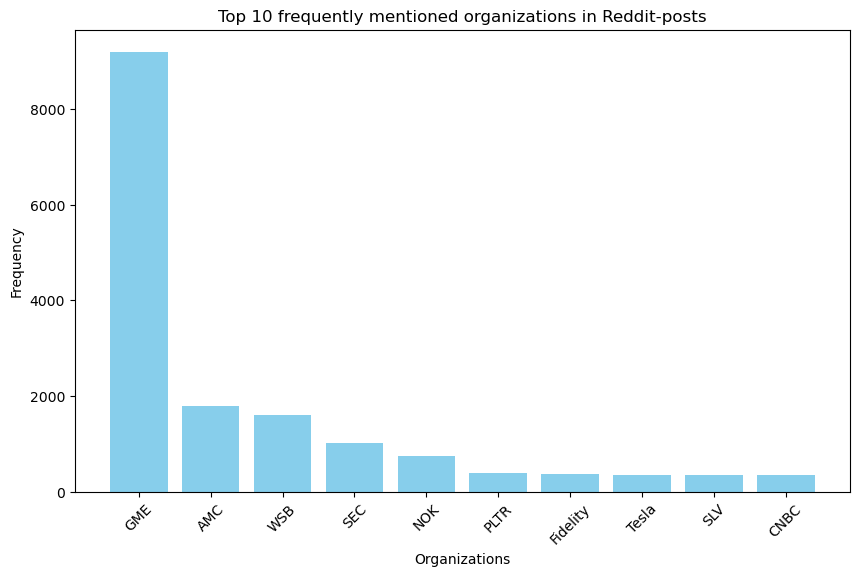

In [74]:
# Plot the 10 most frequent organizations
plt.figure(figsize=(10, 6))
plt.bar(organizations, counts, color='skyblue')

# Add labels and titel
plt.xlabel('Organizations')
plt.ylabel('Frequency')
plt.title('Top 10 frequently mentioned organizations in Reddit-posts')

# Show the graph
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Plot the result of NER before making the text lowercase
doc= nlp(df['clean_body'].iloc[1])
displacy.render(doc, style = 'ent')

In [76]:
df['clean_body'] = df['clean_body'].apply(lambda x: x.lower())
print(df['clean_body'].head(2))


In [ ]:
df['clean_body'] = df['clean_body'].apply(lambda x: " ".join(x.split())) # Remove extra spaces
print(df['clean_body'].head(2))

In [77]:
# Plot the result of NER after making the text lowercase
doc= nlp(df['clean_body'].iloc[1])
displacy.render(doc, style = 'ent')

In [78]:
# Only keep the posts containing 'gme' or 'gamestop'
def filter_dataBy_org():

    filtered_posts = df[df['clean_body'].apply(lambda x: ('gme' in x) | ('gamestop' in x))]
    return filtered_posts

df = filter_dataBy_org()

In [79]:
print(df.shape[0])

6558


Frequency of words in posts concerning GME

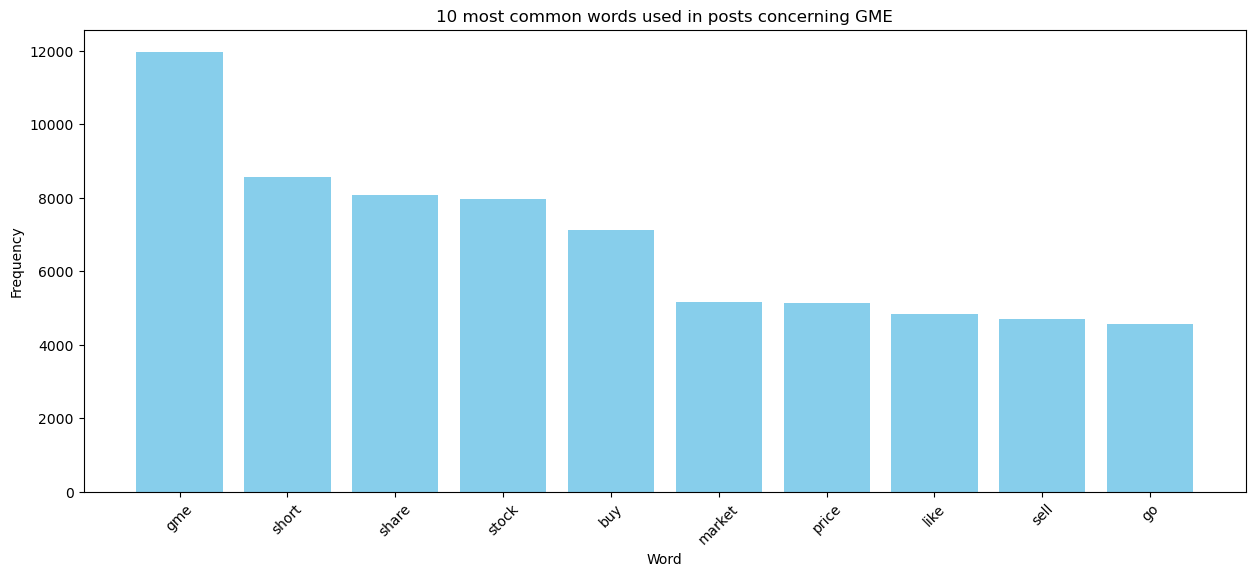

In [80]:
# Tokenize and count word frequencies
def word_freq(post):
    
    doc = nlp(post)

    # Lemmatize and remove stop words
    lemmatized_text = ' '.join([token.lemma_ for token in doc if not token.is_stop and token.is_alpha and len(token.lemma_) > 1])

    # Find words and count their frequencies
    words = re.findall(r'\b\w+\b', lemmatized_text)
    
    word_counts = Counter(words)

    return word_counts 

# Apply the word_freq function on each row in the dataset
df['word_freq'] = df['clean_body'].apply(word_freq)

all_word_counts = Counter()
for freq in df['word_freq']:
    all_word_counts.update(freq)

# Extract the most common words
most_common_words = all_word_counts.most_common(10)
words = [word for word, _ in most_common_words]
freqs = [count for _, count in most_common_words]

# Plot the result
plt.figure(figsize=(15, 6))
plt.bar(words, freqs, color='skyblue')
plt.title('10 most common words used in posts concerning GME')
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()


Development of the GME stock price

[*********************100%***********************]  1 of 1 completed


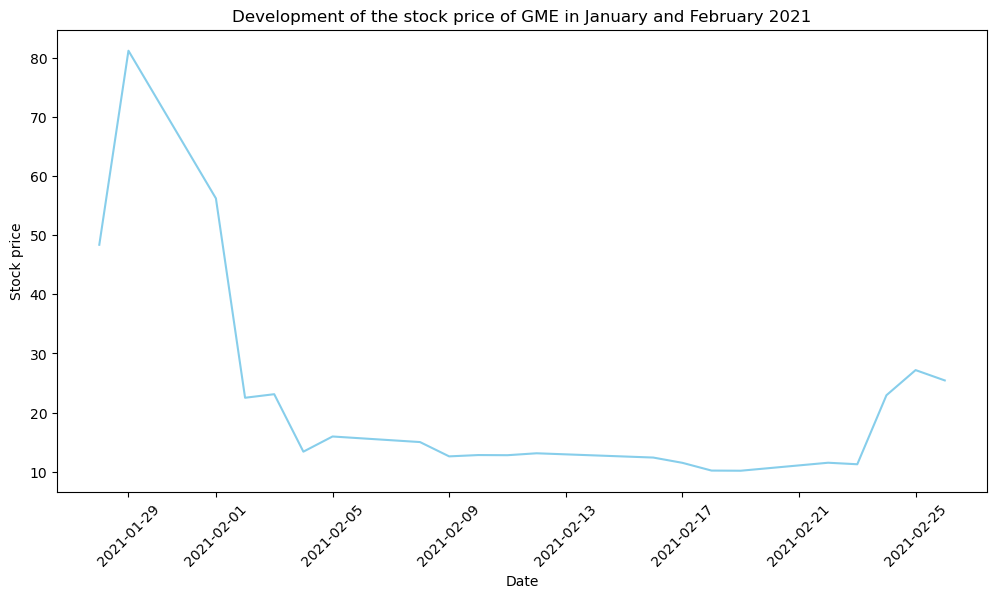

In [81]:
# load historical data for GME for January and February 2021
data_GME = yf.download(tickers='GME', start='2021-01-28', end='2021-02-28', interval = '1d', group_by='Date')

# Identify the closing-price column
close_price = data_GME[('GME','Close')]

# Plot the development of the stock price
plt.figure(figsize=(12, 6))
plt.plot(close_price.index, close_price.values, color='skyblue')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Stock price')
plt.title('Development of the stock price of GME in January and February 2021')

# Show the graph
plt.xticks(rotation=45)
plt.show()

Create subset

In [82]:
def random_subset(input):
    length = len(input)
    size_of_subset = int(length*0.33)

    # Randomly select a subset of posts
    r.seed(size_of_subset) 
    shuffled = input.sample(frac=1, random_state=size_of_subset)
    subset = shuffled.iloc[:size_of_subset]
    return subset.reset_index(drop=True)


In [83]:
df = df.groupby('date', sort=False).apply(lambda x: random_subset(x))

/var/folders/54/r707pzsj7254h2zz2tx96pwc0000gn/T/ipykernel_12932/2740662843.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('date', sort=False).apply(lambda x: random_subset(x))


In [84]:
print(len(df))

2148


Sentiment analysis

In [86]:
def get_positive_score(x):
  
    if x["label"] == "POSITIVE":
        res_x = x['score']

    elif x["label"] == "NEGATIVE":
        res_x = 1 - x['score']
    else:
        raise Exception(x["label"]+"This should not be possible")
    # The result is scaled as [0, 1], but we change the scale to [-1, 1]  
    res_x = res_x*2-1 

    return res_x

def GetSentiment(sentence):
    classifier = pipeline("sentiment-analysis",
                          model = "distilbert-base-uncased-finetuned-sst-2-english",
                          padding = True,
                          truncation = True,
                          max_length = 512,
                          device=0)
    
    result = classifier(sentence)
    score = get_positive_score(result[0]) # Extract the label and the score
    return score
    

In [87]:
# Apply the GetSentiment function on each row in the data frame
df['sentiment_scores'] = df['clean_body'].apply(lambda x: GetSentiment(x)) 

In [88]:
print(df['sentiment_scores'].head(10))

date         
2021-01-28  0   -0.999032
            1   -0.996871
            2   -0.997672
            3   -0.941227
            4   -0.991400
            5   -0.972466
            6   -0.859349
            7   -0.999507
            8   -0.997442
            9   -0.998787
Name: sentiment_scores, dtype: float64


In [89]:
# Save the data frame as a csv file
df.to_csv("data_frame_sentiment.csv")

Visualize the development of the average sentiment of Reddit Posts pr. day

In [ ]:
# Calculate the average sentiment score per day
day_sentiment = df.groupby(level='date')['sentiment_scores'].mean()
plt.figure(figsize=(10, 6))

# Plot the graph
plt.plot(day_sentiment.index, day_sentiment, marker='o', color='skyblue', linestyle='-', linewidth=2)

# Add the labels and title
plt.xlabel('Date')  
plt.ylabel('Average sentiment') 
plt.title('Average sentiment of Reddit posts pr. day')  

# Rotate the labels of the x-axis
plt.xticks(rotation=45)

# Add grids
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()

ZeroShot classification

In [ ]:
def GetEmotions(post, classifier, candidate_labels):
    # Classify the post
    res = classifier(post, candidate_labels)
    
    # Create a dictionary of the labels and scores
    label_score_mapping = {label: score for label, score in zip(res['labels'], res['scores'])}
    
    # Sort the labels and scores such that it matches the the candidate labels
    sorted_labels = [label for label in candidate_labels]
    sorted_scores = [label_score_mapping.get(label, None) for label in candidate_labels]
    
    # Return the result as a dictionary
    return {"labels": sorted_labels, "scores": sorted_scores}

In [ ]:
# Load the model and candidate labels
classifier = pipeline(task="zero-shot-classification",
                      model="facebook/bart-large-mnli",
                      padding=True, 
                      truncation=True, 
                      max_length=512) # To make it work on long pieces of text 

candidate_labels = ["Optimistic","Excited", "Frustrated", "Pessimistic"]

In [ ]:
# Apply the GetEmotions function to each row in the data frame
df['zeroshot'] = df['clean_body'].apply(lambda x: GetEmotions(x, classifier, candidate_labels))

In [ ]:
print(df['sentiment_scores'][0])

In [ ]:
# Store the score for each label in the dataframe
df['Optimistic'] = df['zeroshot'].apply(lambda x: x['scores'][0])
df['Excited'] = df['zeroshot'].apply(lambda x: x['scores'][1])
df['Frustrated'] = df['zeroshot'].apply(lambda x: x['scores'][2])
df['Pessimistic'] = df['zeroshot'].apply(lambda x: x['scores'][3])

In [ ]:
#Save the data as a csv file
df.to_csv("data_frame_zeroshot_4labels.csv")

Plot of the sentiment, emotions and stock price

In [ ]:
# Extract the data from the dataframe for the y-axis
average_emotion_optimistic = df.groupby(level='date')['Optimistic'].mean()
average_emotion_excited = df.groupby(level='date')['Excited'].mean()
average_emotion_frustrated = df.groupby(level='date')['Frustrated'].mean()
average_emotion_pessimistic = df.groupby(level='date')['Pessimistic'].mean()

day_sentiment = df.groupby(level='date')['sentiment_scores'].mean()

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(25, 7))  

# Plot line chart
ax1.plot(average_emotion_optimistic.index, average_emotion_optimistic.values, marker='o',color='green', linestyle='-', linewidth=2, label = "Optimistic")
ax1.plot(average_emotion_excited.index, average_emotion_excited.values, marker='o', color='blue', linestyle='-', linewidth=2, label = "Excited")
ax1.plot(average_emotion_frustrated.index, average_emotion_frustrated.values, marker='o', color='orange', linestyle='-', linewidth=2, label = "Frustrated")
ax1.plot(average_emotion_pessimistic.index, average_emotion_pessimistic.values, marker='o', color='red', linestyle='-', linewidth=2, label = "Pessimistic")

ax1.set_xlabel("Date")
ax1.set_ylabel("Average emotions", color='black')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_title("Average emotions of Reddit posts")
ax1.legend()

# Average sentiment
ax2.plot(day_sentiment.index, day_sentiment.values, label='Average sentiment score pr. day', color='grey')
ax2.set_xlabel("Date")
ax2.set_ylabel("Average sentiment score", color='grey')
ax2.tick_params(axis='y', labelcolor='grey')
ax2.set_title("GME Stock Price vs. average sentiment score ")


# GME stock price
ax3 = ax2.twinx() 
ax3.plot(close_price.index, close_price.values, color='black')
ax3.set_ylabel("GME stock price", color='black')
ax3.tick_params(axis='y', labelcolor='black')


fig.tight_layout()  

# Show the graphs
plt.show()

In [ ]:
plt.figure(figsize=(15, 7))

# Plot line chart
plt.plot(average_emotion_optimistic.index, average_emotion_optimistic.values, marker='o',color='green', linestyle='-', linewidth=2, label = "Optimistic")
plt.plot(average_emotion_excited.index, average_emotion_excited.values, marker='o', color='blue', linestyle='-', linewidth=2, label = "Excited")
plt.plot(average_emotion_frustrated.index, average_emotion_frustrated.values, marker='o', color='orange', linestyle='-', linewidth=2, label = "Frustrated")
plt.plot(average_emotion_pessimistic.index, average_emotion_pessimistic.values, marker='o', color='red', linestyle='-', linewidth=2, label = "Pessimistic")

plt.xlabel("Date")
plt.ylabel("Average emotions", color='black')
plt.tick_params(axis='y', labelcolor='blue')
plt.title("Average emotions of Reddit posts")
plt.legend()



fig.tight_layout()  

# Show the graphs
plt.show()

Perfomance evaluation

In [ ]:
first_test = df.iloc[150]
print(first_test)
print(first_test['body'])
print(first_test['sentiment_scores'])
print(first_test['zeroshot'])

In [ ]:
second_test = df.iloc[1767]
print(second_test)
print(second_test['body'])
print(second_test['sentiment_scores'])
print(second_test['zeroshot'])